In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from collections import Counter
from scipy.stats import sem
from utils import *
warnings.filterwarnings('ignore')

# Generate a random graph
A function that given a number of nodes and vertices, generates an adjacency matrix of a random graph (https://en.wikipedia.org/wiki/Random_graph).

In [2]:
#create random directed graph
def gen_random_graph(nodeCount,vertexCount):

    adj = np.zeros((nodeCount,nodeCount)) #Adjacency Matrix

    vertices = {}

    while len(vertices) < vertexCount:

        x = random.randint (0, nodeCount-1)
        y = random.randint (0, nodeCount-1)

        if x == y: continue

        w = random.uniform(-2.0,2.0) # pick random values for weights
        vertices [x, y] = w

    for k in vertices:

        x = k[0]
        y = k[1]

        adj[x,y] = vertices[k]
        
    return adj
    

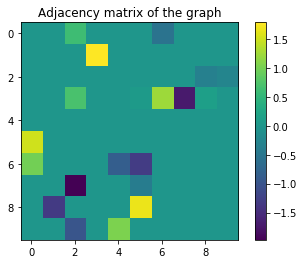

In [4]:
N_genes = 10

adj = gen_random_graph(nodeCount=N_genes,vertexCount=20)

#Plot
plt.imshow(adj,interpolation='None')
plt.title('Adjacency matrix of the graph')
plt.colorbar();

# Gene Network model
We follow the gene graph model by Mendes et al (https://www.ncbi.nlm.nih.gov/pubmed/14534181?dopt=Abstract).

We calculate transcription factor as result of activations and inhibitions: they have both a sigmoidal shape that depends on some parameters.

In [5]:
def calc_inib(adj,x,j,K,n):
    
    mask = adj[:,j] < 0
    
    k_ = K**n
    
    inib = np.prod(k_/(x[mask]**n + k_))
    
    return inib



def calc_actv(adj,x,l,K,n):
    
    mask = adj[:,l] > 0
    k_ = K**n
    
    actv = np.prod(1 + x[mask]**n/(x[mask]**n + k_))

    return actv


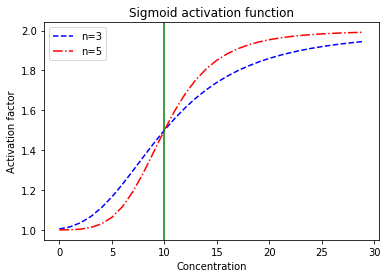

In [6]:
#Try to visualize the sigmoid for different concentration values
K = 12
x = np.array([1])

steps = np.arange(30)
a = np.ones((1,2))
meas1 = []
meas2 = []

for i in steps:
    x += 1
    meas1.append(calc_actv(a,x,0,K,3))
    meas2.append(calc_actv(a,x,0,K,5))
    
    
#plot measurements
plt.plot(steps,meas1,'--',c='b',label='n=3')
plt.plot(steps,meas2,'-.',c='r',label='n=5')
plt.axvline(10,c='g',)
plt.title('Sigmoid activation function')
plt.legend()
plt.xlabel('Concentration')
plt.ylabel('Activation factor');

In [7]:
def update_state(x,adj,b,rate):
    
    K = 10
    n = 3
    
    x_new = np.zeros_like(x)
    
    for i,x_i in enumerate(x):
        
        actv = calc_actv(adj,x,i,K,n)
        inib = calc_inib(adj,x,i,K,n)  
        
        if actv == 1.0 and inib == 1.0:
            actv = 0.0
        
        x_new[i] = x_i + rate[i] * actv * inib - b[i] * x_i
       
    return x_new

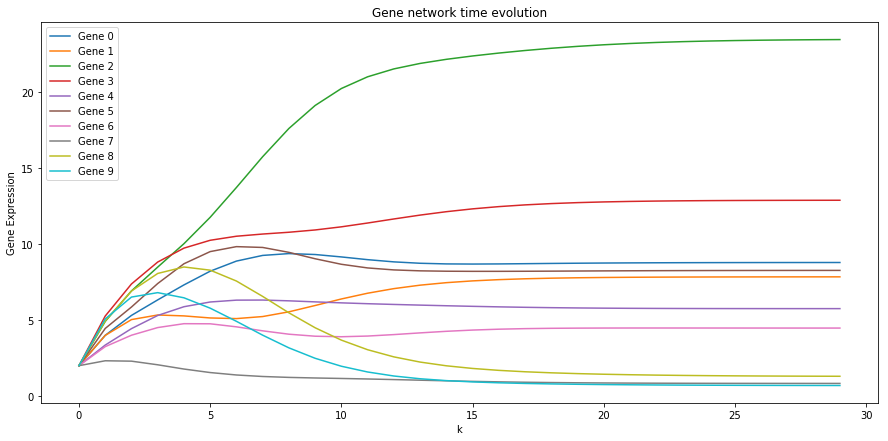

In [8]:
from numpy.linalg import norm

N_genes = adj.shape[0]
x = 2*np.ones(adj.shape[0])

rate_st = 2.8
b_st = 0.5 

rate = np.zeros(N_genes)
b = np.zeros(N_genes)

steps = 0
measures_list = []

delta_min = 1e-2
convergence = False

#Biological variance
#0.0 -> gene breakdown
#2.0 -> doubled transcription
for i in range(N_genes):

    rate[i] = rate_st * np.random.uniform(low=0.5,high=1.5)
    b[i] = b_st * np.random.uniform(low=0.5,high=1.5)



while not convergence :
    
    x_new = update_state(x,adj,b,rate)
    
    measures_list.append(x)
    steps += 1
    
    #check convergence
    if norm(x_new - x) < delta_min:
        
        x = x_new
        
        convergence = True
    else:
        x = x_new
        
        
measures = np.asarray(measures_list)


#Plot
plt.figure(figsize=(15, 7))

for i in range(N_genes):
         
    plt.plot(np.arange(steps),measures[:,i],label='Gene {}'.format(i))
    plt.xlabel('k')
    plt.ylabel('Gene Expression')
    plt.title('Gene network time evolution')
    plt.grid()
    plt.legend()

# Synthetic dataset generation

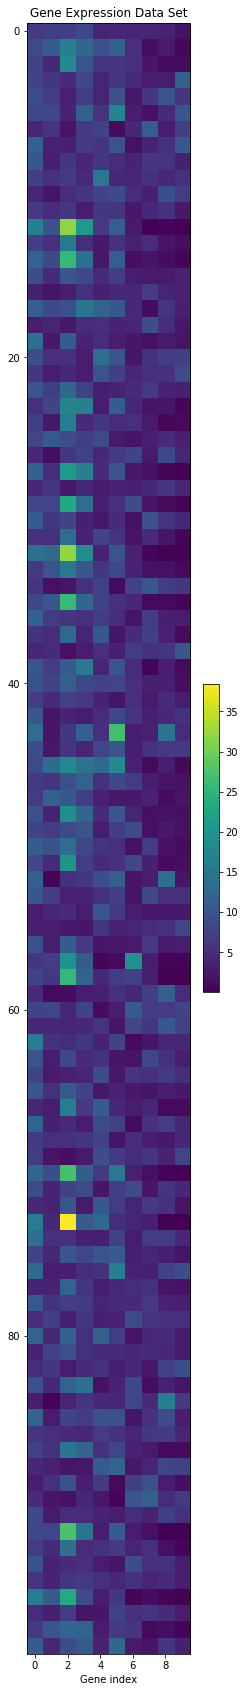

In [10]:
#Create a syntethic DS carrying out N different experiments

N_samples = 100
N_measures_list = []
N_genes = adj.shape[0]
sigma_n = 0.05 #noise power

for N in np.arange(N_samples):
    
    x = np.random.uniform(low=0.0,high=100.0,size=N_genes)
    
    rate_st = 2.8
    b_st = 0.5 
    
    rate = np.zeros(N_genes)
    b = np.zeros(N_genes)

    delta_min = 1e-6
    convergence = False

    #Biological variance
    #0.0 -> gene breakdown
    #2.0 -> doubled transcription
    for i in range(N_genes):
        
        rate[i] = rate_st * np.random.uniform(low=0.5,high=1.5)
        b[i] = b_st * np.random.uniform(low=0.5,high=1.5)

    while not convergence :

        x_new = update_state(x,adj,b,rate)
        
        #check convergence
        if norm(x_new - x) < delta_min:

            x_new += sigma_n*np.random.normal(size=N_genes) #Additive noise on the measurement
            N_measures_list.append(x_new)
            convergence = True
        else:
            x = x_new
            
N_measures = np.asarray(N_measures_list)


#Plot        
plt.figure(figsize=(6, 30))
plt.imshow(N_measures,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('Gene index')
plt.title('Gene Expression Data Set');

In [10]:
"""
#Computationally very expensive: use it just for dataset with N_genes < 10
#
#Visualize pairs of genes one vs one plot to point out obvious correlations

import pandas as pd

df = pd.DataFrame(N_measures)

sm = pd.scatter_matrix(df, diagonal='kde',alpha=0.7,figsize=(8, 6))

for i,subaxis in enumerate(sm):
      
    for ax in subaxis:
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.set_xlabel('G{}'.format(i))
        ax.set_ylabel('G{}'.format(i))
        
""";

# ARACNE

## Mutual Information calculation
ARACNE calculates MI using a Kernel Density Estimation method as explained in "Estimation of Mutual Information Using Kernel Density Estimators" Moon et al.(1995). 
this approach is robust in finding values inequalities, although it is not the best choice if we would have a precise estimate of MI.
h is the Kernel width. relative inequalities are almost insensitive to the choice of h. we set h using a euristic approach.

In [15]:
#Calculate matrix of pairwise column Mutual Information 
def calc_matMI(N_measures):

    N_genes = N_measures.shape[1]
    
    matMI = np.zeros((N_genes, N_genes))
    
    for ix in np.arange(N_genes):
        for jx in np.arange(ix+1,N_genes):
            
            # save time by calculating only half matrix above the diagonal
            matMI[ix,jx] = kernel_mi(N_measures[:,ix], N_measures[:,jx])
    
    return matMI

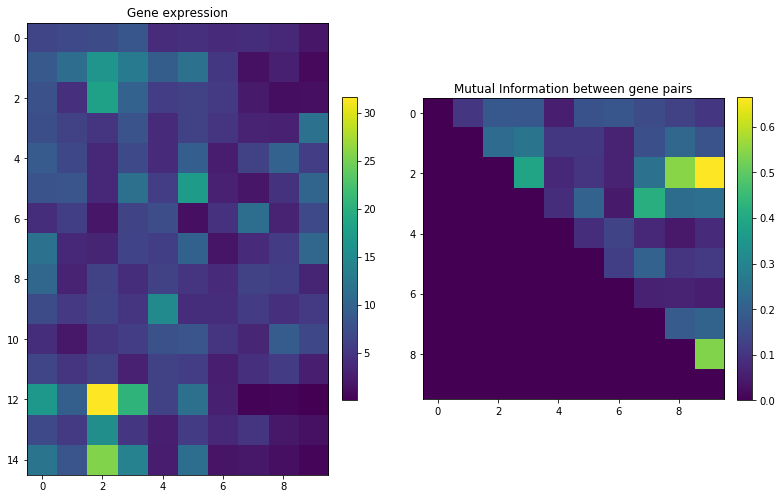

In [12]:
matMI = calc_matMI(N_measures)


#Plot        
plt.figure(figsize=(13, 13))

plt.subplot(121)
plt.imshow(N_measures[:15],interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Gene expression')

plt.subplot(122)
plt.imshow(matMI,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Mutual Information between gene pairs');


# Threshold I_0

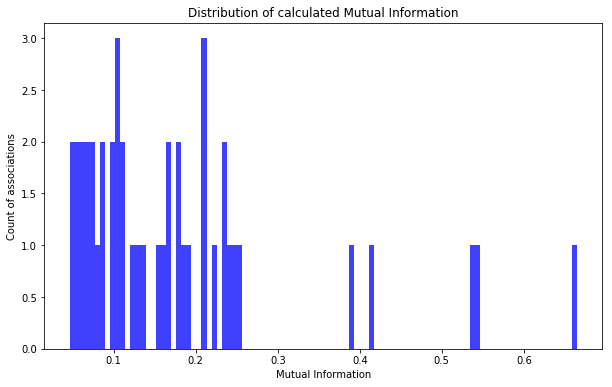

In [13]:
# chart MI vs Counts

dummy = np.ndarray.flatten(matMI)
idxx = np.where(dummy != 0)
MI_list = np.ndarray.tolist(dummy[idxx])



#Plot
plt.figure(figsize=(10, 6))

bins = np.linspace(min(MI_list), max(MI_list), 101)

plt.hist(MI_list, bins, facecolor='b',alpha=0.75)
plt.xlabel('Mutual Information')
plt.ylabel('Count of associations')
plt.title('Distribution of calculated Mutual Information');

The paper suggests a procedure to calculate a sensible value of the threshold I_0: we shuffle each row of the dataset in order to "destroy" the correlations among them. then we calculate MI matrix for the shuffled data; MI values are lower n average and the maximum value is a reasonable choice for the threshold; we can repeat the procedure many times in order to have a better estimation of I_0.

In [16]:
#Permutation
N_perm = 1
matMI_perm = np.zeros((N_perm,N_genes, N_genes))
max_val = np.zeros(N_perm)

X = []

#repeat N_perm times
for n in np.arange(N_perm):
    
    #row shuffling
    for i in np.arange(N_samples):
    
        indices = np.random.permutation(N_genes)
        X.append(N_measures[i,indices])

    shuffled_X = np.asarray(X)
    
    #calculate MI of the shuffled matrix
    matMI_perm[n,:,:] = calc_matMI(shuffled_X)
    max_val[n] = np.amax(matMI_perm[n,:,:])                        
                                   


matMI_alternative = np.mean(matMI_perm,axis=0)


dummy = np.ndarray.flatten(matMI_alternative)
idx = np.where(dummy != 0)
MI_list2 = np.ndarray.tolist(dummy[idx])

Maximum MI value for the shuffled matrix: 0.1530


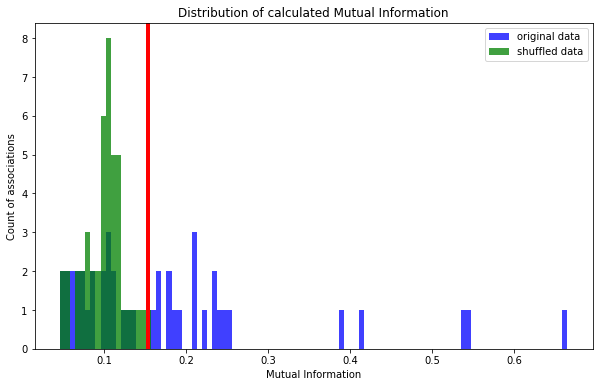

In [17]:
#Plot
plt.figure(figsize=(10, 6))

plt.hist(MI_list, bins,facecolor='b', alpha=0.75,label='original data')
plt.hist(MI_list2, bins,facecolor='g', alpha=0.75,label='shuffled data')
plt.legend(loc='upper right')

plt.axvline(np.amax(matMI_alternative),c='r',linewidth=4)
plt.xlabel('Mutual Information')
plt.ylabel('Count of associations')
plt.title('Distribution of calculated Mutual Information');

print('Maximum MI value for the shuffled matrix: {0:.4f}'.format(np.mean(max_val)))

Let's filter connections below the threshold.

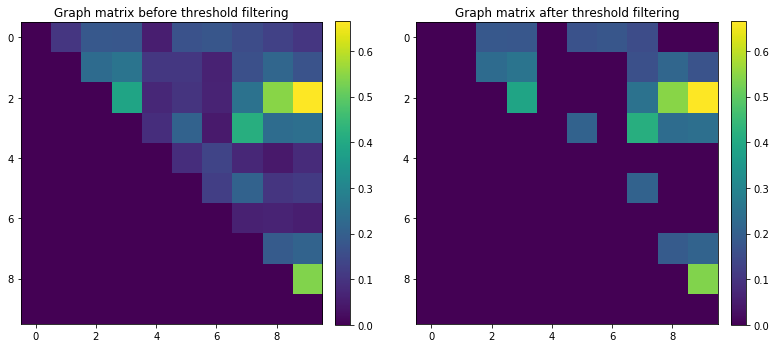

In [18]:
#We pick as I_0 the max value of MI in the average of the permuted distributions

#threshold
matMI_filtered = np.copy(matMI)
I_0 = np.amax(matMI_alternative)

idx = np.where(matMI_filtered < I_0)
matMI_filtered[idx] = 0

#Plot
plt.figure(figsize=(13, 13))

plt.subplot(121)
plt.imshow(matMI,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Graph matrix before threshold filtering');

plt.subplot(122)
plt.imshow(matMI_filtered,interpolation='None')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Graph matrix after threshold filtering');

# Data Processing Inequality
We get rid of the loops in the reconstructed graph.

In [19]:
def DPI(M,i,j,k):
    
    dic = {0: (i,j),
           1: (i,k),
           2: (j,k)}
    
    dpi_list = [M[i,j],M[i,k],M[j,k]]
    idx = np.argmin(dpi_list)
    
    return dic[idx]

In [20]:
def filter_loops(M):

    set_to_zero = []

    #find the candidates. Complexity O(N^3)
    for i in np.arange(M.shape[0]):

        idx_j = np.where(M[i] != 0)[0]

        for j in idx_j:

            idx_k = np.where(M[j] != 0)[0]

            for k in idx_k:
                
                #print('i:{},j:{},k:{}'.format(i,j,k))
                if M[i,k] != 0:
                    set_to_zero.append(DPI(M,i,j,k))
    
    #set to zero & plot final matrix
    for idx in set_to_zero:

        M[idx] = 0

    return M

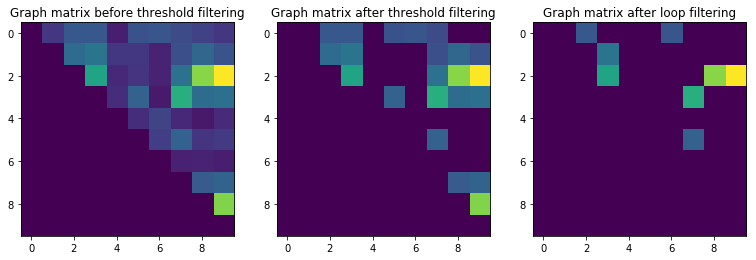

In [21]:
#plot    
plt.figure(figsize=(13, 13))

plt.subplot(131)
plt.imshow(matMI,interpolation='None')
plt.title('Graph matrix before threshold filtering');

plt.subplot(132)
plt.imshow(matMI_filtered,interpolation='None')
plt.title('Graph matrix after threshold filtering');

matMI_filtered = filter_loops(matMI_filtered)

plt.subplot(133)
plt.imshow(matMI_filtered,interpolation='None')
plt.title('Graph matrix after loop filtering');

# Network reconstruction & score calculation
When we reconstruct the graph we loose information about edge's directions. If we would like to recover it we should use temporal data and not only the steady state of the system.

In [22]:
def calc_masks(adj,matMI):

    mask = adj != 0
    mask_real = np.logical_or(mask,mask.T) #make the matrix symmetric

    mask_infe = matMI != 0
    mask_infe = np.logical_or(mask_infe,mask_infe.T)

    return mask_real,mask_infe

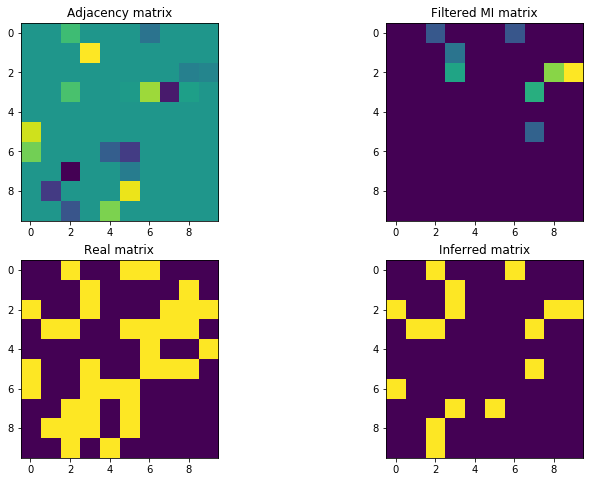

In [23]:
mask_real,mask_infe = calc_masks(adj,matMI_filtered)

#Plot        
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(adj,interpolation='None')
plt.title('Adjacency matrix')

plt.subplot(222)
plt.imshow(matMI_filtered,interpolation='None')
plt.title('Filtered MI matrix')

plt.subplot(223)
plt.imshow(mask_real,interpolation='None',cmap='viridis')
plt.title('Real matrix')

plt.subplot(224)
plt.imshow(mask_infe,interpolation='None',cmap='viridis')
plt.title('Inferred matrix');

In [24]:
def calc_acc(mask_real,mask_infe):
    
    FN = np.count_nonzero(mask_real)    
    TP = np.count_nonzero(np.logical_and(mask_real,mask_infe))
    FP = np.count_nonzero(np.logical_xor(mask_infe,np.logical_and(mask_real,mask_infe)))

    if TP == 0:
        precision = 0
    else:
        precision = TP/(FP+TP)
        
    recall = TP/FN
    
    return precision,recall

precision,recall = calc_acc(mask_real,mask_infe)


print('Precision: {}'.format(round(precision,2)))
print('Recall: {}'.format(round(recall,2)))

Precision: 1.0
Recall: 0.44


# How results change for different values of I_0
When we filter by I_0 we preliminary eliminates candidates for gene interactions. Take into account that even in absence of I_0 ARACNE eliminates all loops with DPI

Let's visualize precision and recall curves depending on I_0 values.

In [25]:
I_0list = np.linspace(start=0.0,stop=np.max(matMI),num=10)
prec_list = []
reca_list = []


for I_0 in I_0list:
    
    matMI_filtered = np.copy(matMI)
    
    #filter by threshold
    idx = np.where(matMI < I_0)
    matMI_filtered[idx] = 0
    
    #DPI inequality
    matMI_filtered = filter_loops(matMI_filtered)
    
    mask_real,mask_infe = calc_masks(adj,matMI_filtered)
    precision,recall = calc_acc(mask_real,mask_infe)
    
    prec_list.append(precision)
    reca_list.append(recall)

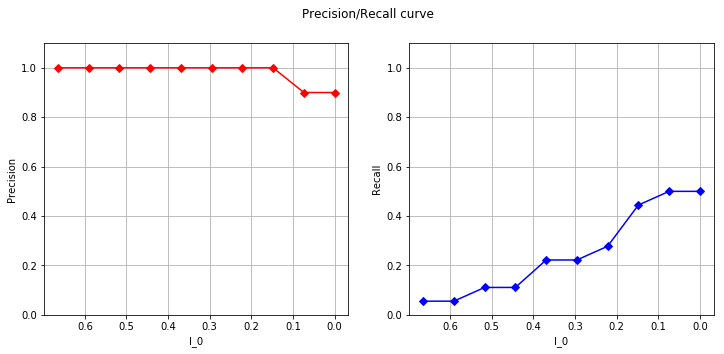

In [26]:
#Plot        
plt.figure(figsize=(12, 5))
plt.suptitle('Precision/Recall curve')

plt.subplot(121)
plt.gca().invert_xaxis()
plt.plot(I_0list,prec_list,'-Dr')
plt.grid()
plt.gca().set_ylim(0, 1.1)
plt.xlabel('I_0')
plt.ylabel('Precision')

plt.subplot(122)
plt.gca().invert_xaxis()
plt.plot(I_0list,reca_list,'-Db')
plt.grid()
plt.gca().set_ylim(0, 1.1)
plt.xlabel('I_0')
plt.ylabel('Recall');